In [ ]:
import pandas as pd
import altair as alt

# Enable the data transformer for large datasets
alt.data_transformers.enable('default', max_rows=None)

# Load the dataset
names = pd.read_csv('dpt2020.csv', sep=';')

# Drop rows with '_PRENOMS_RARES' and 'XX'
names = names[(names['preusuel'] != '_PRENOMS_RARES') & (names['dpt'] != 'XX')]

# Check if the necessary columns exist
required_columns = {'preusuel', 'sexe', 'annais', 'nombre'}
if not required_columns.issubset(names.columns):
    raise ValueError(f"Dataset is missing required columns: {
                     required_columns - set(names.columns)}")

# Check for null values and handle them if necessary
if names.isnull().any().any():
    names = names.dropna()  # Drop rows with any null values

# Convert 'annais' to int and handle conversion errors
names['annais'] = pd.to_numeric(names['annais'], errors='coerce')
# Drop rows where 'annais' could not be converted to numeric
names = names.dropna(subset=['annais'])
names['annais'] = names['annais'].astype(int)

# Interactive controls
gender_select = alt.binding_select(
    options=['Both', 'Male', 'Female'], name='Gender: ')
gender_selection = alt.param(
    bind=gender_select, value='Both', name='Gender'
)

type_select = alt.binding_select(
    options=['Top all Time', 'Top Per Year'], name='Type: ')
type_selection = alt.param(
    bind=type_select, value='Top Per Year', name='Type'
)

start_year_slider = alt.binding_range(
    min=1900, max=2020, step=1, name='Start Year:')
start_year_selection = alt.param(
    bind=start_year_slider, value=1900, name='Start_Year'
)

end_year_slider = alt.binding_range(
    min=1900, max=2020, step=1, name='End Year:')
end_year_selection = alt.param(
    bind=end_year_slider, value=2020, name='End_Year'
)

# Define the base chart
base = alt.Chart(names).transform_calculate(
    Gender=alt.expr.if_(alt.datum.sexe == 1, 'Male', 'Female'),
    Type='"Top Per Year"'  # Fix this line to use a literal string
).transform_filter(
    (alt.datum.annais >= alt.expr.toNumber(start_year_selection)) &
    (alt.datum.annais <= alt.expr.toNumber(end_year_selection)) &
    (
        (alt.datum.sexe == 1 & (alt.expr.toString(gender_selection) == 'Male')) |
        (alt.datum.sexe == 2 & (alt.expr.toString(gender_selection) == 'Female')) |
        (alt.expr.toString(gender_selection) == 'Both')
    )
).mark_line().encode(
    x=alt.X('annais:O', title='Year'),
    y=alt.Y('sum(nombre):Q', title='Number of Babies'),
    color=alt.Color('preusuel:N', title='Name'),
    tooltip=['annais', 'preusuel', 'sum(nombre)']
).properties(
    width=1200,
    height=600,
    title='Popularity of Top Baby Names Over Time'
).add_params(
    gender_selection,
    type_selection,
    start_year_selection,
    end_year_selection
)

# Apply the selections to the chart
final_chart = base

final_chart

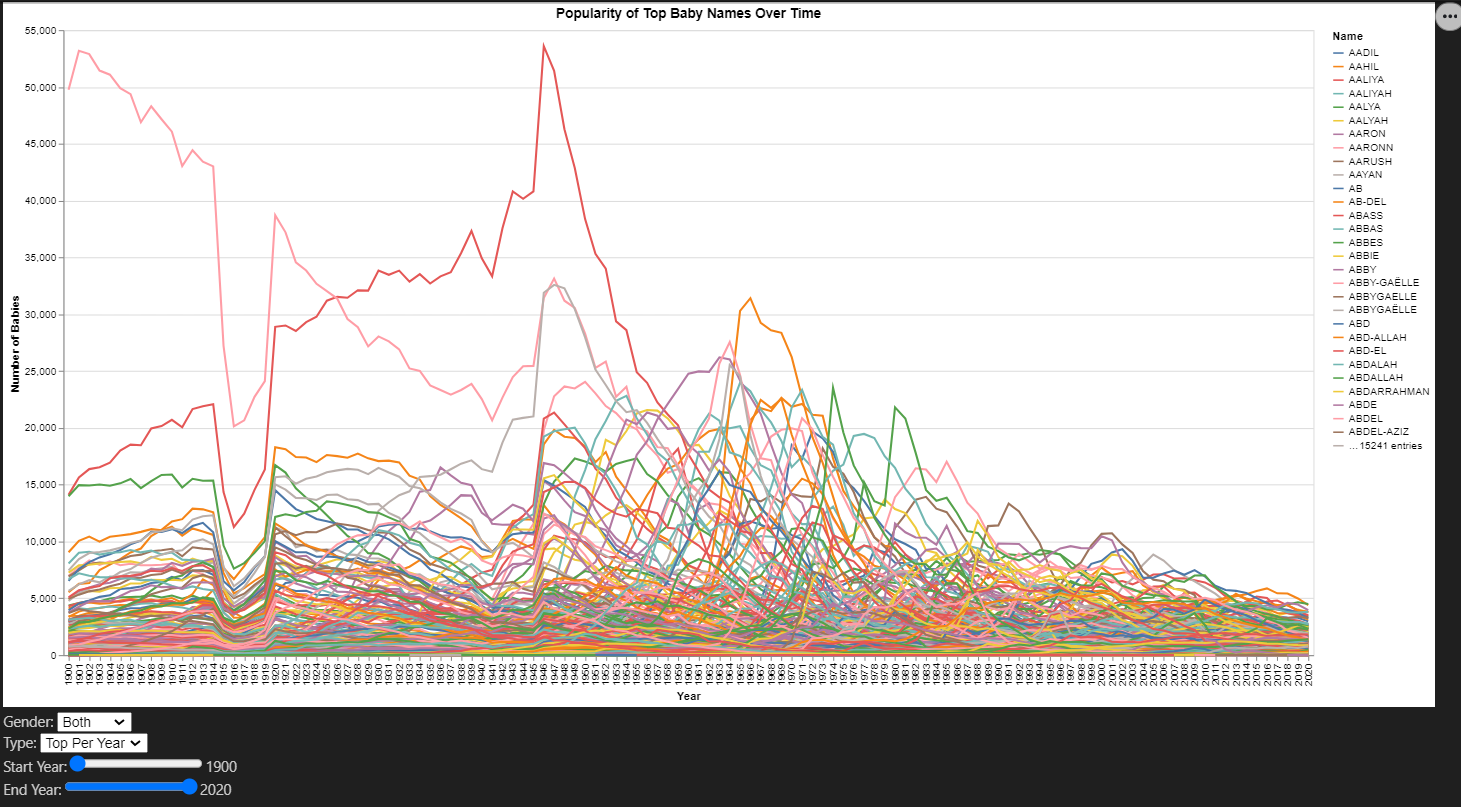